#### Імопрт необхідний бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tensorflow as tf

from typing import Tuple
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback, History

tf.config.list_physical_devices("GPU")

2024-12-21 14:19:48.859620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734787188.874525  255916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734787188.878988  255916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 14:19:48.893782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Формат вхідних даних (збережений JSON документ)

In [2]:
!head -n 23 "BTC-USD_2018-01-01_2023-01-01.json"

[
    {
        "high": 13921.53,
        "low": 12877.67,
        "open": 13850.49,
        "volumefrom": 78425.21,
        "volumeto": 1057521524.42,
        "close": 13444.88,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2018-01-01"
    },
    {
        "high": 15306.13,
        "low": 12934.16,
        "open": 13444.88,
        "volumefrom": 137732.17,
        "volumeto": 1956783037.35,
        "close": 14754.13,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2018-01-02"
    },


#### Створення dataframe на основі збереженого JSON документу

In [3]:
cols = ["date", "open", "close", "high", "low"]

df = pd.read_json("BTC-USD_2018-01-01_2023-01-01.json")[cols]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1826 non-null   float64
 1   close   1826 non-null   float64
 2   high    1826 non-null   float64
 3   low     1826 non-null   float64
dtypes: float64(4)
memory usage: 71.3 KB


In [4]:
df.describe()

,open,close,high,low
count,1826.000000,1826.000000,1826.000000,1826.000000
mean,20325.323269,20326.777996,20867.617738,19708.610372
std,16986.465564,16986.036451,17448.148243,16452.915674
min,3232.510000,3232.510000,3271.760000,3169.530000
25%,7683.202500,7683.130000,7940.472500,7467.587500
50%,10951.120000,10951.120000,11286.925000,10630.015000
75%,33696.752500,33696.752500,34868.867500,32212.095000
max,67549.140000,67549.140000,68978.640000,66312.420000


#### Графік реальних даних - коливання курсу BTC/USD у 2018 - 2022 роках

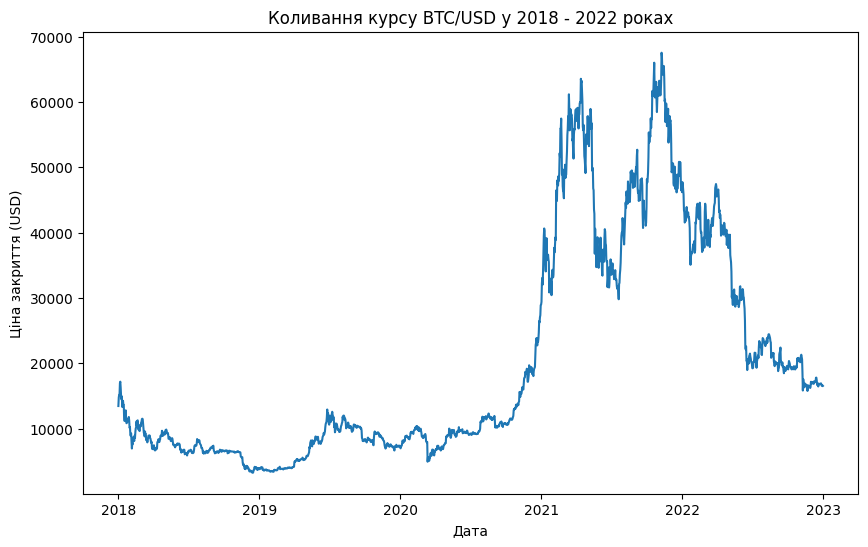

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df["close"])
plt.title("Коливання курсу BTC/USD у 2018 - 2022 роках")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.show()

#### Реалізація "Callback" для збереження проміжних прогнозів під час навчання

In [6]:
class PredRecorder(Callback):
    def __init__(self, X, scaler: MinMaxScaler, interval: int = 1) -> None:
        super().__init__()
        self.X = X
        self.scaler = scaler
        self.interval = interval
        self.y_preds = []

    def on_epoch_end(self, epoch: int, logs=None) -> None:
        if epoch == 0 or (epoch + 1) % self.interval == 0:
            Y_pred = self.model.predict(self.X, verbose=0)
            Y_pred_inv = self.scaler.inverse_transform(Y_pred)
            self.y_preds.append(Y_pred_inv)

    def get_preds(self) -> np.ndarray:
        return self.y_preds

#### Нормалізація вхідних даних та створення наборів даних для навчання; розділення даних на тренувальну та тестову вибірки

In [7]:
data = df[["close"]].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset: np.ndarray, look_back: int) -> Tuple[np.ndarray, np.ndarray]:
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i - look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

#### Створення та навчання моделі; прогнозування на тестовій вибірці

In [8]:
interval = 10
pred_recorder = PredRecorder(X_test, scaler, interval=interval)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

fit_kwargs = {
    "verbose": 1,
    "epochs": 50,
    "batch_size": 16,
    "validation_data": (X_test, Y_test),
    "callbacks": [pred_recorder, early_stopping],
}

model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

history = model.fit(X_train, Y_train, **fit_kwargs)

Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred).flatten()

I0000 00:00:1734787190.999382  255916 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2267 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1734787193.099290  255986 cuda_dnn.cc:529] Loaded cuDNN version 90300


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0119 - val_loss: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7657e-04 - val_loss: 0.0016
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0750e-04 - val_loss: 0.0017
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 7.8634e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8919e-04 - val_loss: 9.3995e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7522e-04 - val_loss: 7.8740e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9842e-04 - val_loss: 0.0010
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4029e-04 - val_loss: 0.0013
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7779e-04 - val_loss: 0.0013
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

#### Оцінка моделі (метрики MSE, RMSE, MAE, R², MAPE)

In [9]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"R2: {r2:.4f}\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.4f}%")

evaluate_model(df["close"][len(X_train) + look_back:], Y_pred)

R2: 0.9894
MAE: 686.9242
MSE: 1087863.2827
RMSE: 1043.0068
MAPE: 2.4162%


#### Графік Loss / Validation Loss

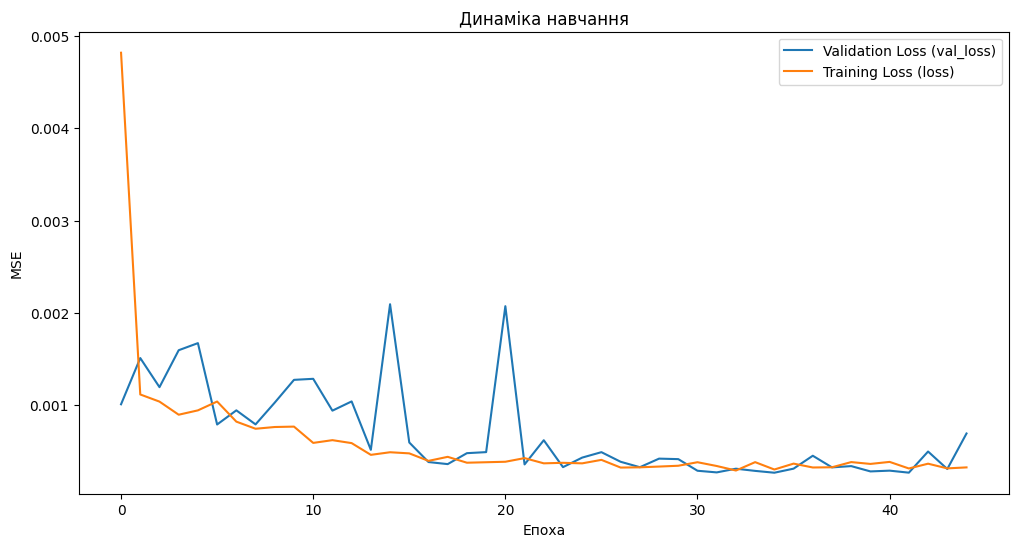

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["val_loss"], label="Validation Loss (val_loss)")
plt.plot(history.history["loss"], label="Training Loss (loss)")
plt.title("Динаміка навчання")
plt.xlabel("Епоха")
plt.ylabel("MSE")
plt.legend()
plt.show()

#### Графік реальних та прогназовних даних

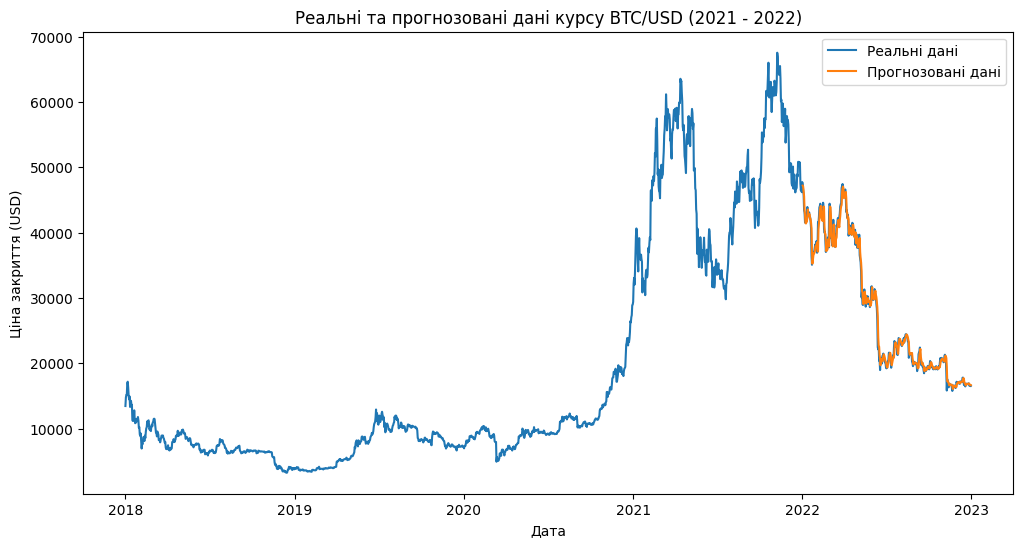

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["close"], label="Реальні дані")
plt.plot(df.index[len(X_train) + look_back:], Y_pred, label="Прогнозовані дані")
plt.title("Реальні та прогнозовані дані курсу BTC/USD (2021 - 2022)")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Графіки прогнозів моделі під час навчання (кожні interval епох)

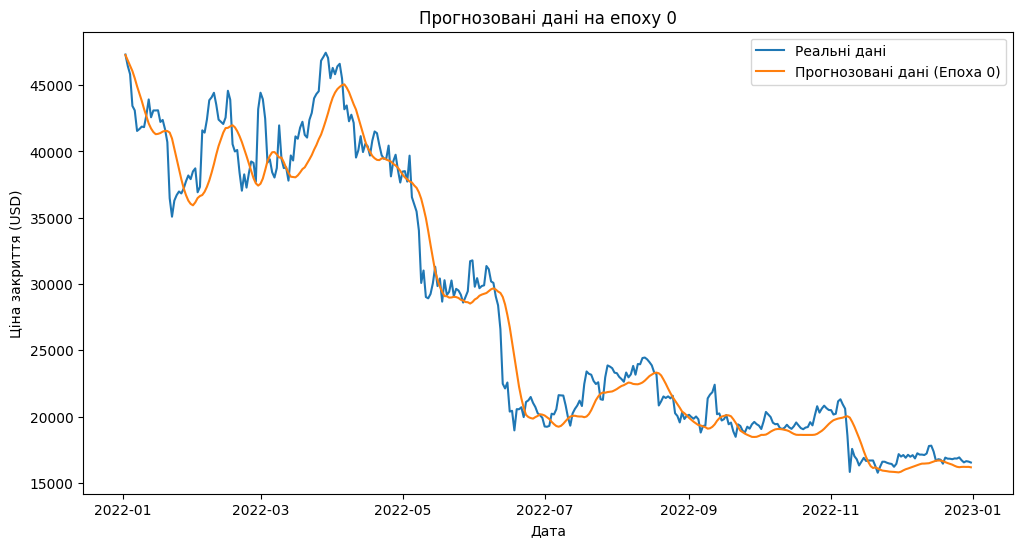

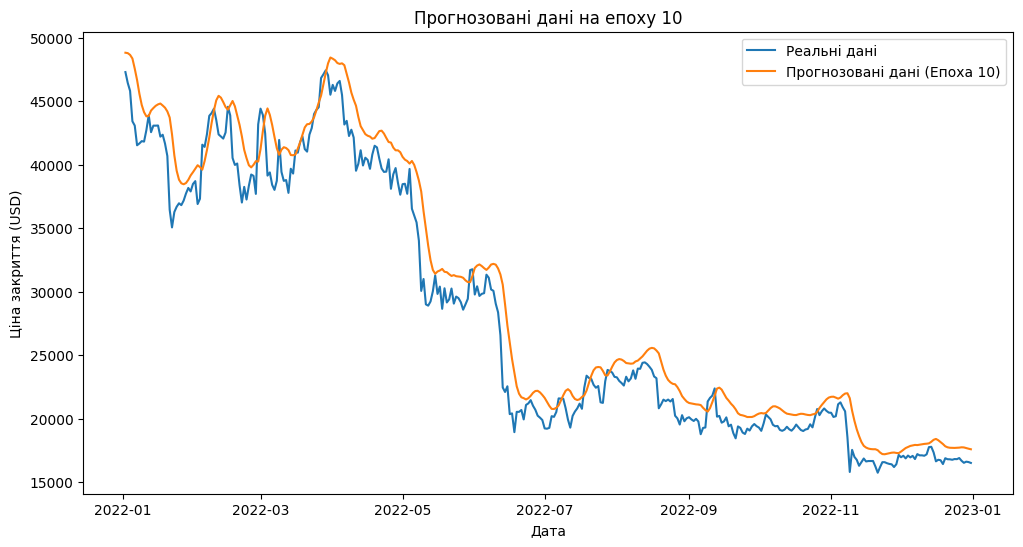

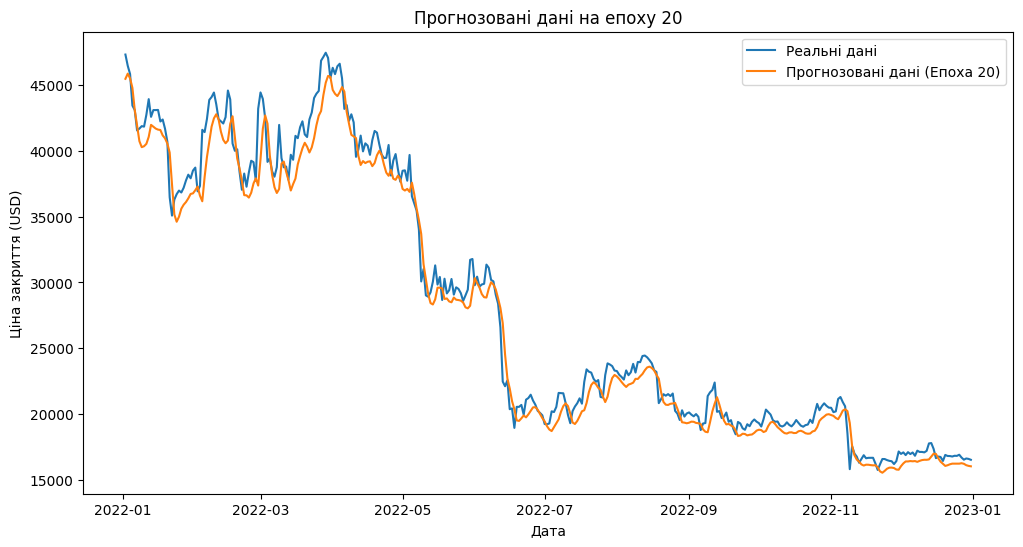

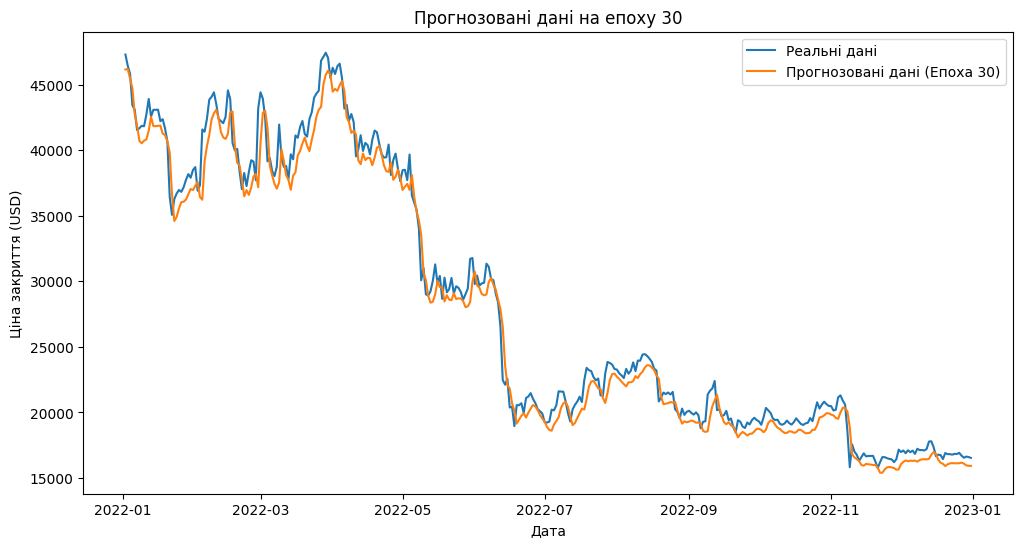

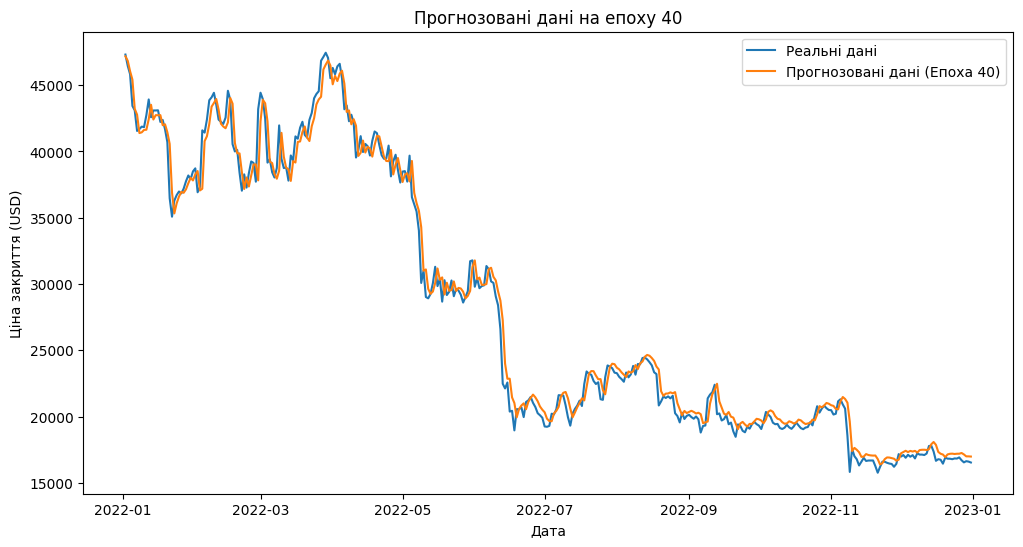

In [12]:
y_preds = pred_recorder.get_preds()

for epoch, y_pred in enumerate(y_preds):
    epoch = epoch * interval
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[len(X_train) + look_back:], df["close"][len(X_train) + look_back:], label="Реальні дані")
    plt.plot(df.index[len(X_train) + look_back:], y_pred.flatten(), label=f"Прогнозовані дані (Епоха {epoch})")
    plt.title(f"Прогнозовані дані на епоху {epoch}")
    plt.xlabel("Дата")
    plt.ylabel("Ціна закриття (USD)")
    plt.legend()
    plt.show()

#### Дослідження залежності точності моделі від її структури

Training model with 32 LSTM units and 1 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R2: 0.9591
MAE: 1475.0529
MSE: 4205183.3797
RMSE: 2050.6544
MAPE: 5.2685%


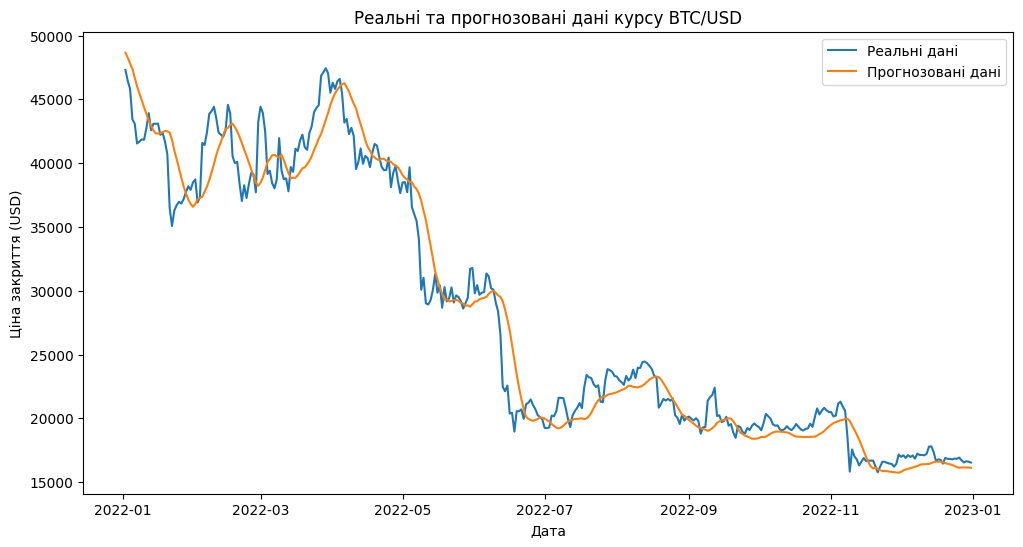

Training model with 32 LSTM units and 2 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
R2: 0.9767
MAE: 1045.7233
MSE: 2398118.5138
RMSE: 1548.5860
MAPE: 3.6892%


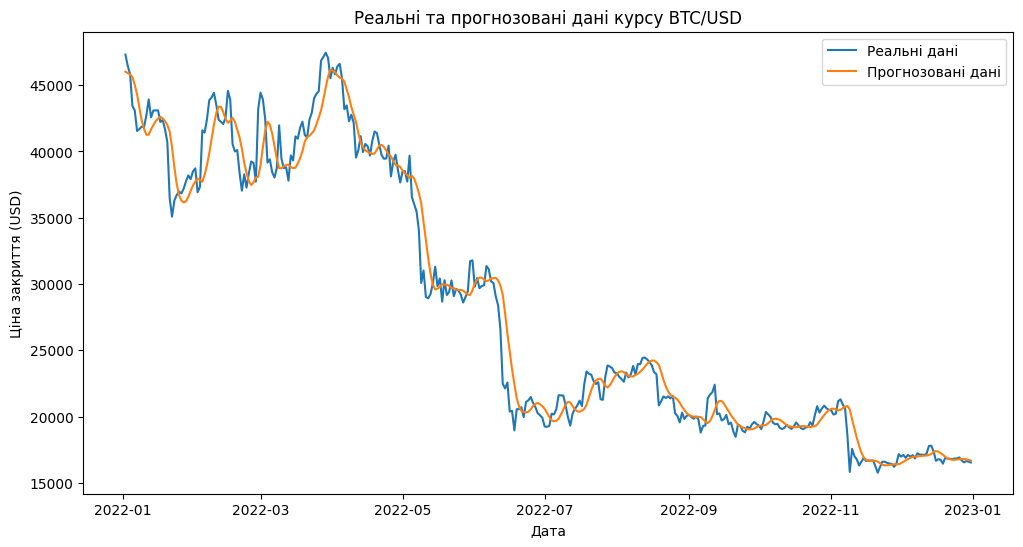

Training model with 32 LSTM units and 3 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
R2: 0.9494
MAE: 1609.7395
MSE: 5205420.7534
RMSE: 2281.5391
MAPE: 5.7604%


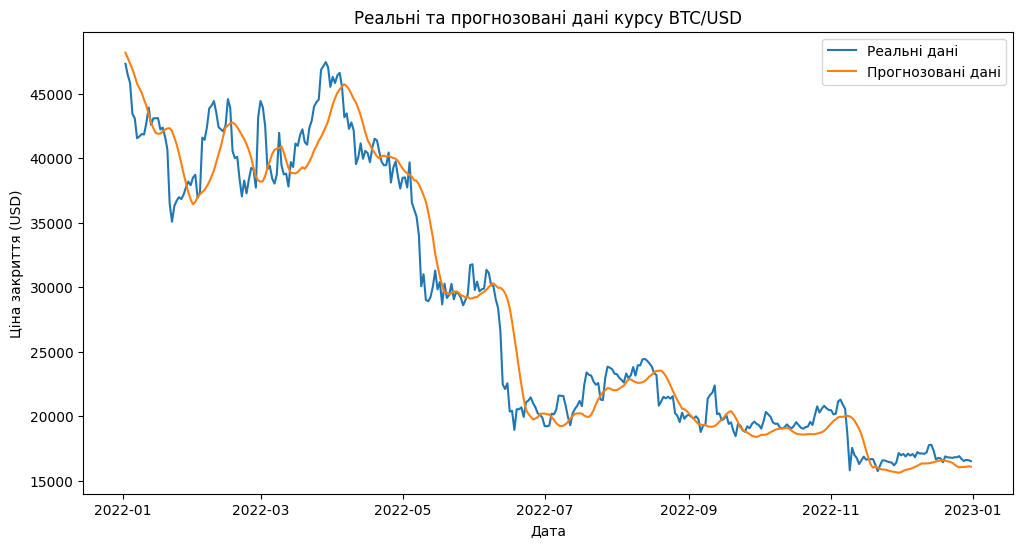

Training model with 64 LSTM units and 1 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R2: 0.9658
MAE: 1350.2203
MSE: 3517841.1708
RMSE: 1875.5909
MAPE: 4.7940%


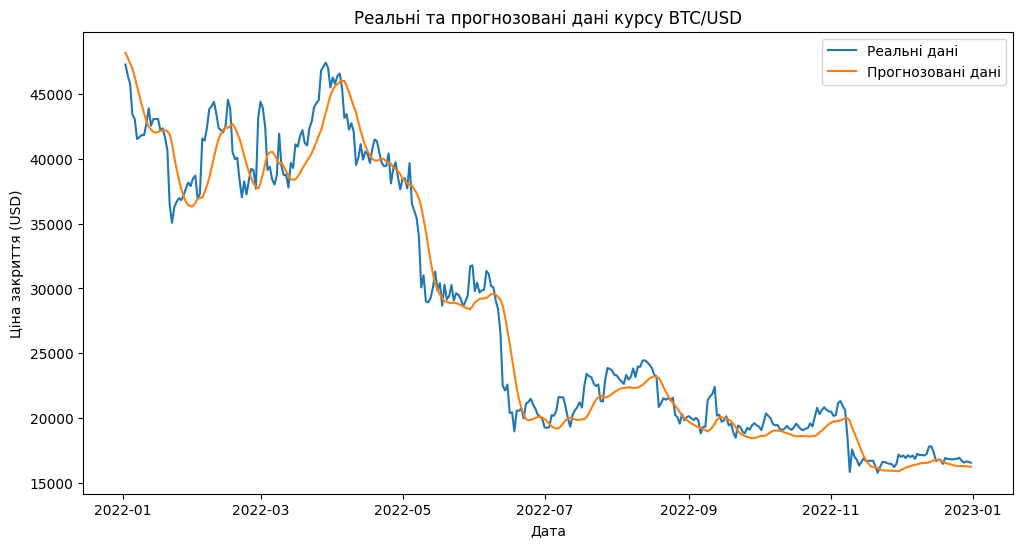

Training model with 64 LSTM units and 2 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
R2: 0.9859
MAE: 816.9318
MSE: 1447882.9914
RMSE: 1203.2801
MAPE: 2.8787%


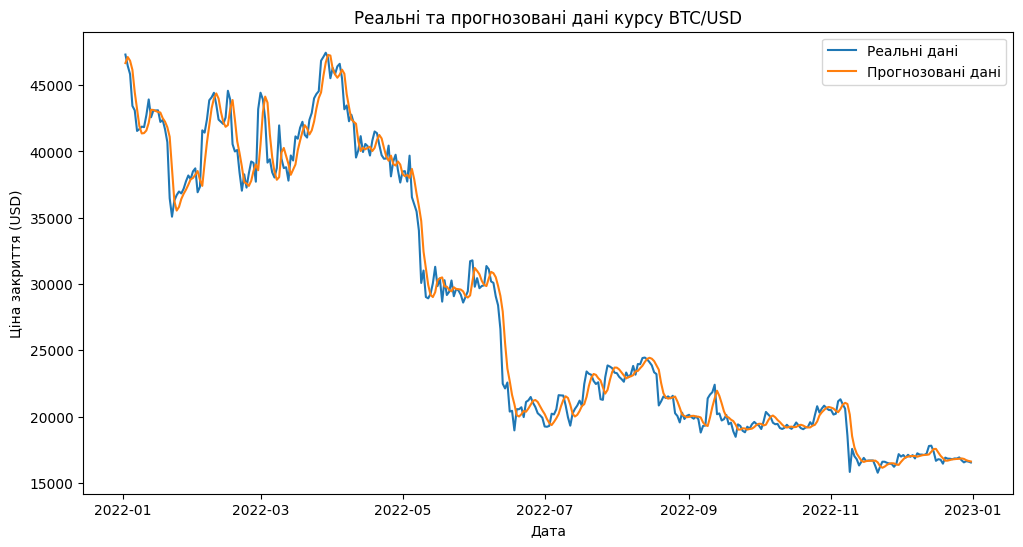

Training model with 64 LSTM units and 3 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
R2: 0.9495
MAE: 1598.0256
MSE: 5200238.8836
RMSE: 2280.4032
MAPE: 5.6483%


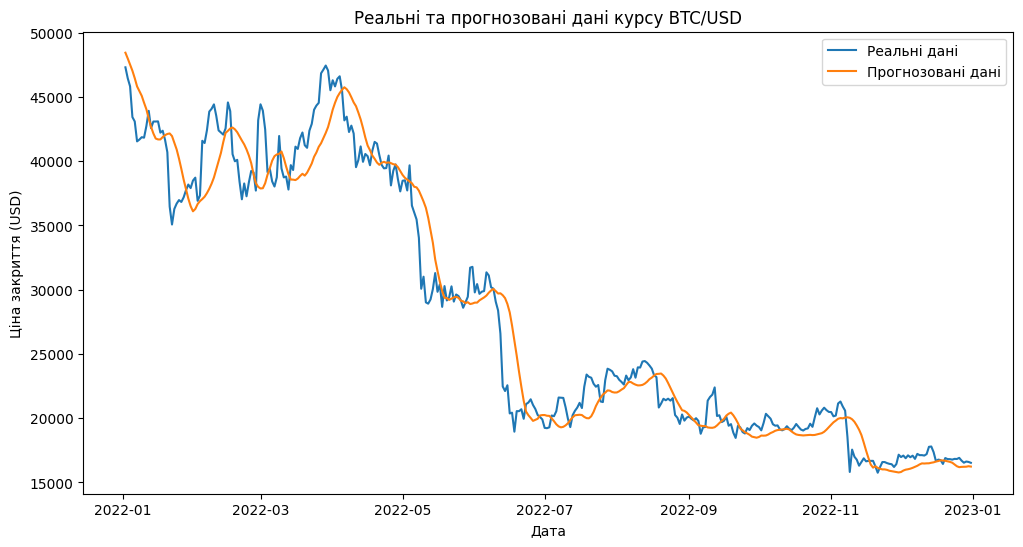

Training model with 128 LSTM units and 1 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R2: 0.9741
MAE: 1101.6379
MSE: 2669659.8622
RMSE: 1633.9094
MAPE: 3.8830%


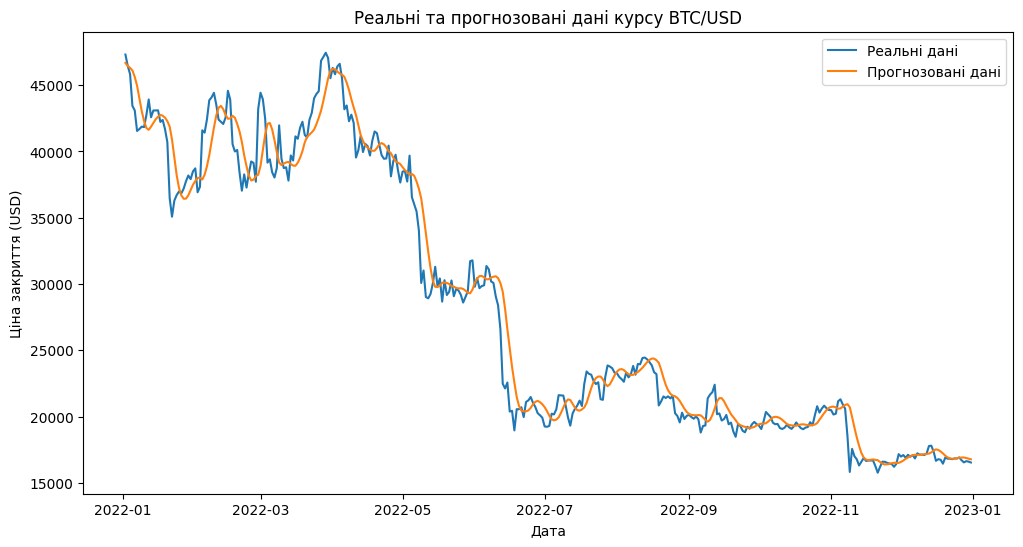

Training model with 128 LSTM units and 2 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
R2: 0.9886
MAE: 721.7151
MSE: 1174359.5557
RMSE: 1083.6787
MAPE: 2.5530%


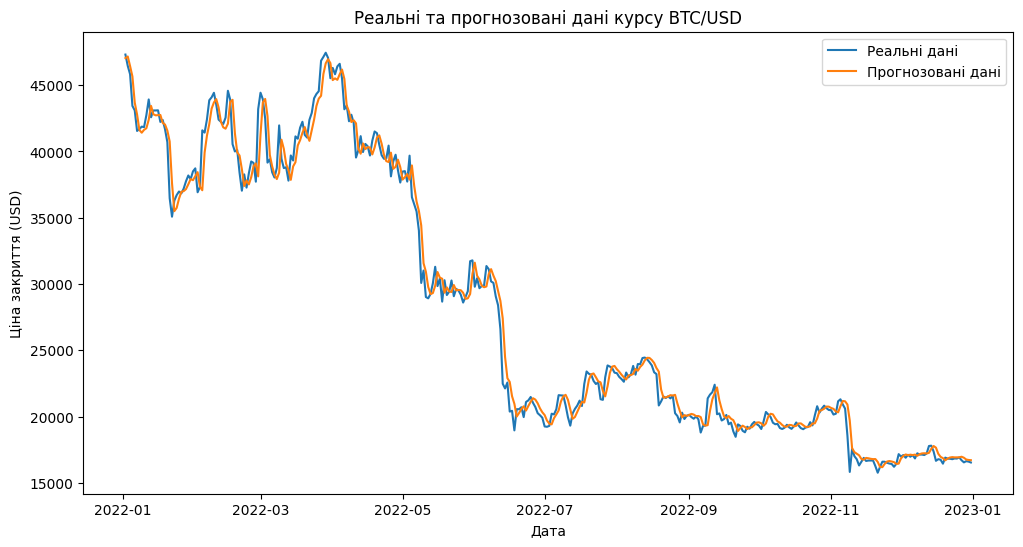

Training model with 128 LSTM units and 3 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
R2: 0.9858
MAE: 826.2370
MSE: 1456636.9970
RMSE: 1206.9122
MAPE: 2.8988%


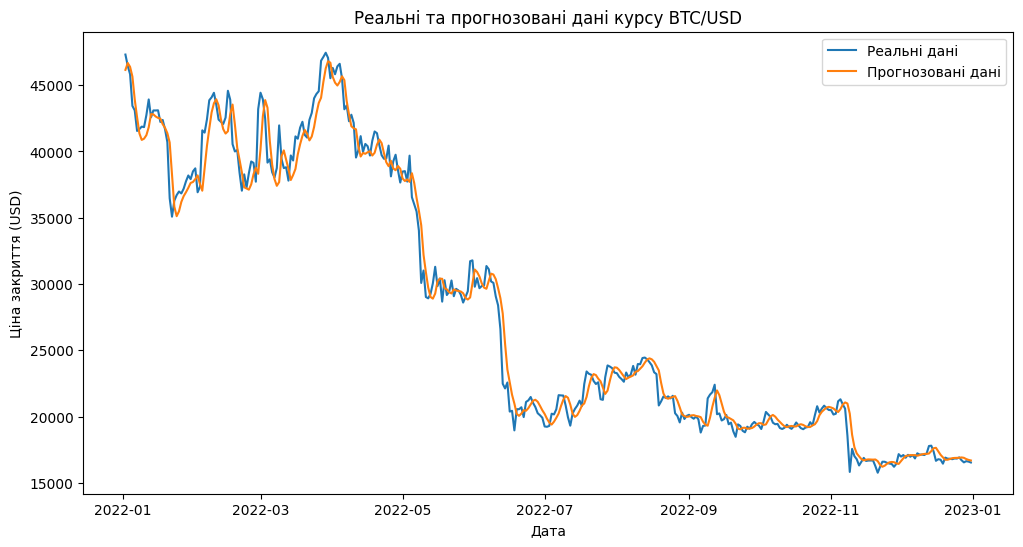

Training model with 256 LSTM units and 1 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
R2: 0.9876
MAE: 755.5275
MSE: 1276195.2973
RMSE: 1129.6881
MAPE: 2.6352%


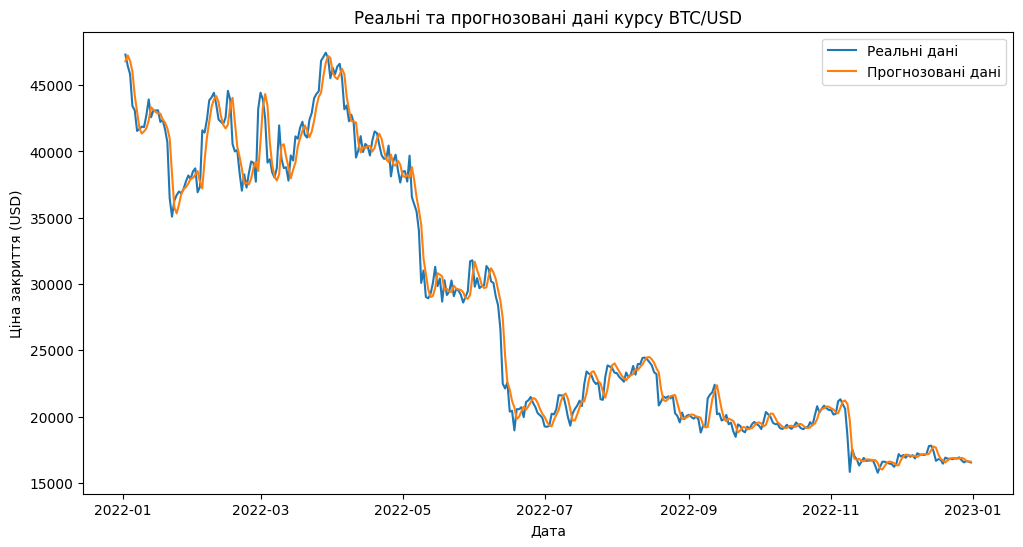

Training model with 256 LSTM units and 2 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
R2: 0.9848
MAE: 884.6772
MSE: 1562627.7125
RMSE: 1250.0511
MAPE: 3.0726%


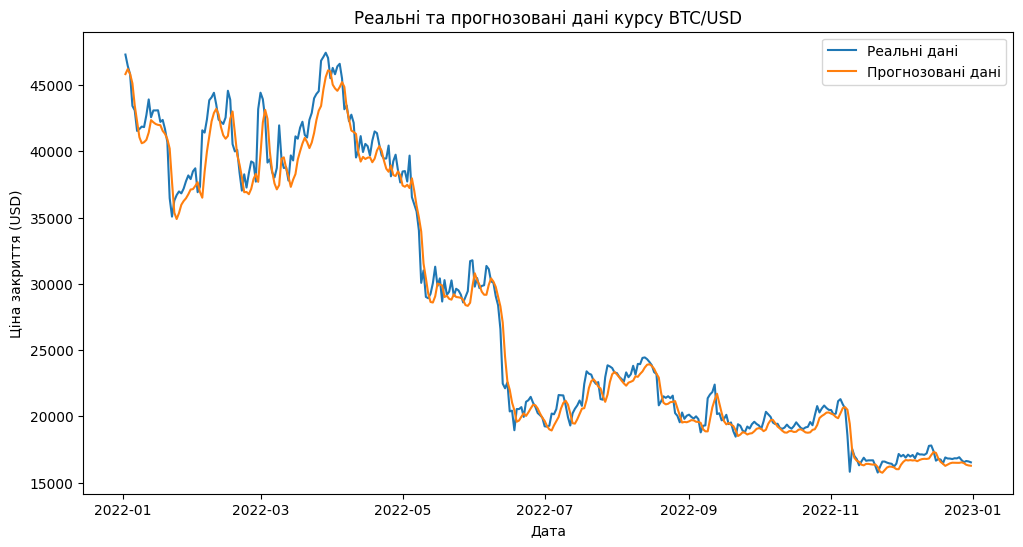

Training model with 256 LSTM units and 3 layers
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
R2: 0.9890
MAE: 700.1556
MSE: 1131501.2411
RMSE: 1063.7205
MAPE: 2.4589%


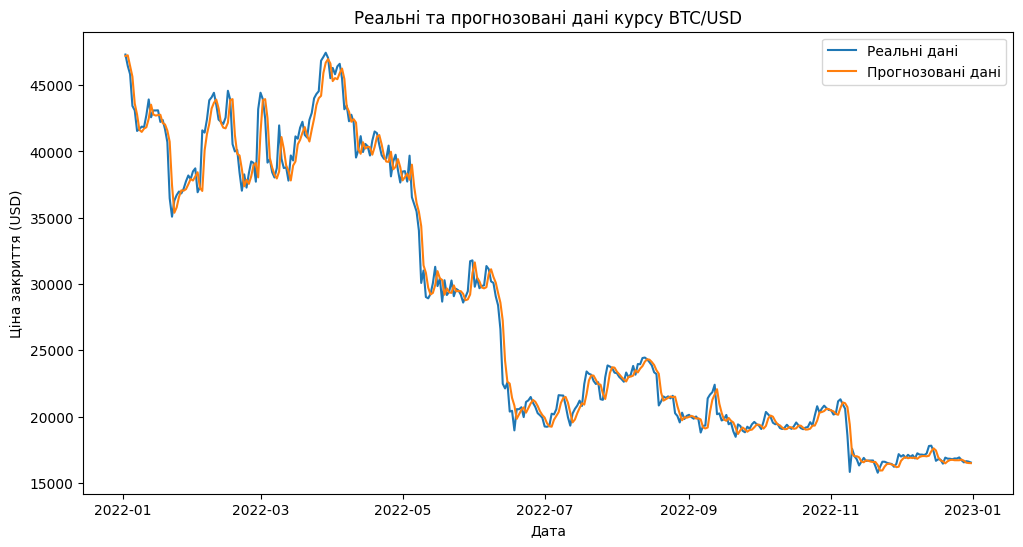

In [16]:
def build_and_train_model(
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    look_back: int,
    lstm_units: int,
    num_layers: int,
) -> Tuple[Sequential, History]:
    early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
    fit_kwargs = {
        "verbose": 0,
        "epochs": 50,
        "batch_size": 32,
        "validation_data": (X_test, Y_test),
        "callbacks": [early_stopping],
    }
    
    model = Sequential()
    model.add(Input(shape=(look_back, 1)))
    
    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        model.add(LSTM(lstm_units, return_sequences=return_sequences))
    
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    
    history = model.fit(X_train, Y_train, **fit_kwargs)

    return model, history

def evaluate_and_plot(
    model: Model,
    scaler: MinMaxScaler,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    X_train: np.ndarray,
    df: pd.DataFrame,
    look_back: int,
) -> None:
    Y_pred = model.predict(X_test)
    Y_pred = scaler.inverse_transform(Y_pred).flatten()
    
    evaluate_model(df["close"][len(X_train) + look_back:], Y_pred)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[len(X_train) + look_back:], df["close"][len(X_train) + look_back:], label="Реальні дані")
    plt.plot(df.index[len(X_train) + look_back:], Y_pred, label="Прогнозовані дані")
    plt.title("Реальні та прогнозовані дані курсу BTC/USD")
    plt.xlabel("Дата")
    plt.ylabel("Ціна закриття (USD)")
    plt.legend()
    plt.show()


look_back = 10
lstm_units_list = [32, 64, 128, 256]
num_layers_list = [1, 2, 3]

for lstm_units in lstm_units_list:
    for num_layers in num_layers_list:
        print(f"Training model with {lstm_units} LSTM units and {num_layers} layers")
        model, _history = build_and_train_model(X_train, Y_train, X_test, Y_test, look_back, lstm_units, num_layers)
        evaluate_and_plot(model, scaler, X_test, Y_test, X_train, df, look_back)